In [12]:
import soundfile as sf
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from pydub import AudioSegment

In [13]:
def get_median_frequency(samples, fs):
    envelope = np.abs(hilbert(samples))
    fft_envelope = np.fft.fft(envelope)
    fft_envelope_magnitude = 20 * np.log10(np.abs(fft_envelope))
    freqs = np.fft.fftfreq(len(envelope), d=1/fs)

    # Filter the frequency range for 17,000–19,000 Hz
    breathing_range = (freqs >= 17300) & (freqs <= 18700)
    filtered_freqs = freqs[breathing_range]
    filtered_magnitudes = fft_envelope_magnitude[breathing_range]

    # Calculate the median amplitude frequency
    sorted_indices = np.argsort(filtered_magnitudes)
    median_index = sorted_indices[len(sorted_indices) // 2]
    median_amplitude_freq = filtered_freqs[median_index]
    return median_amplitude_freq

In [14]:
audio = AudioSegment.from_file("data/demo_pushpull2.caf", format="caf")
samples = np.array(audio.get_array_of_samples())
fs = audio.frame_rate
segment_duration = int(fs/2) 

median_frequencies = []
annotations = []
time_seconds = []

for i in range(0, len(samples), segment_duration):
    segment = samples[i:i + segment_duration]
    if len(segment) < segment_duration:
        break 
    median_freq = get_median_frequency(segment, fs)
    median_frequencies.append(median_freq)
    time_seconds.append(i // fs)  
    if median_freq > 18000:
        annotations.append("Push")
    elif median_freq < 18000:
        annotations.append("Pull")
    else:
        annotations.append("Neutral")
    time.sleep(0.01)

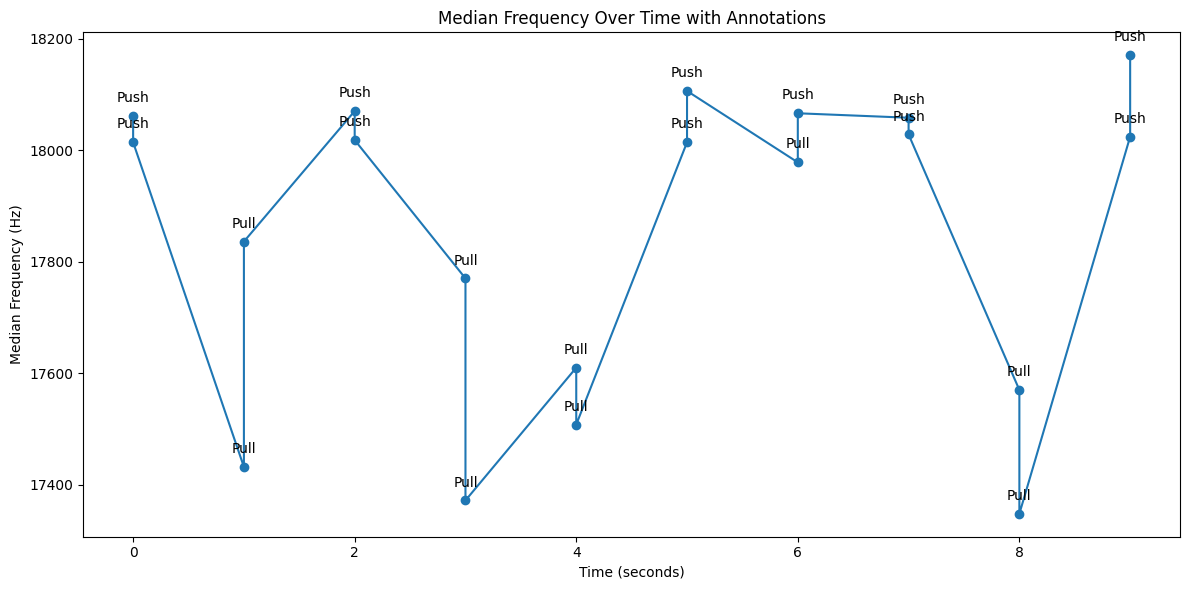

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time_seconds, median_frequencies, marker='o', linestyle='-')
ax.set_title("Median Frequency Over Time with Annotations")
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Median Frequency (Hz)")

for i, (x, y, label) in enumerate(zip(time_seconds, median_frequencies, annotations)):
    ax.annotate(label, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

plt.tight_layout()
plt.show()